# Dataset preprocessing and analysis

In [1]:
import os
import re

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sarcsdet.utils.count_metrics import (
    get_ngrams,
    count_ngrams,
    n_common_ngrams, 
    count_metrics,
    create_metrics_df
)
from sarcsdet.utils.preprocess_data import Preprocessor

### Get data

In [2]:
data_path = '../data/Sarcasm_on_Reddit'

In [3]:
train = pd.read_csv(os.path.join(data_path, 'rus-train-balanced-sarcasm.csv'))

In [4]:
train.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,rus_comment,rus_parent_comment
0,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,"Вы ведь знаете, что западные команды играют пр...",Блейзеры и Mavericks (5-е и 6-е место на Запад...
1,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,"Раньше они были аутсайдерами, но после того, к...",Они хотят побеждать.
2,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,"Этот мем не смешной, как и «ниггер из Нью-Йорка».","ублюдок, не убивай мой кайф"
3,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,Я мог бы использовать один из этих инструментов.,"Да, могу подтвердить, что видел инструмент, ко..."
4,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?,"Я не обращаю на нее внимания, но пока она зако...",ты находишь Ариану Гранде сексуальной?


In [5]:
train['rus_comment'] = train['rus_comment'].astype('str')
train['rus_parent_comment'] = train['rus_parent_comment'].astype('str')

## Delete non russian alphabet

In [6]:
alphabet = {
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    ' ', '!', '#', '%', '&', '*', '+', ',', '.', '/', '~',
    ':', ';', '=', '?', '@', '\\', '^', '{', '|', '}',
    '"', '$', "'", '(', ')', '<', '>', '[', ']', '№',
    '-', '_', '̶', '‐', '‑', '‒', '–', '—', '―', '−', '─',
    'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П',
    'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я',
    'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п',
    'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё',
}

In [7]:
def clear_text(text):
    clear_text = ''
    for letter in text: 
        if letter in alphabet:
            clear_text += letter
    return clear_text

In [8]:
train['rus_comment'] = train['rus_comment'].apply(clear_text)
train['rus_parent_comment'] = train['rus_parent_comment'].apply(clear_text)

In [9]:
train['rus_comment'] = train['rus_comment'].str.strip()
train['rus_parent_comment'] = train['rus_parent_comment'].str.strip()

In [10]:
train['rus_comment'] = train['rus_comment'].apply(lambda s: ' '.join(s.split()))
train['rus_parent_comment'] = train['rus_parent_comment'].apply(lambda s: ' '.join(s.split()))

In [11]:
train['rus_comment'] = train['rus_comment'].apply(
    lambda s: re.sub(r'''^[! ,?'"#%&*+.\/~:;=@\\\^{|}$\(\)\[\]<>№_]* ''', '', s)
)

train['rus_parent_comment'] = train['rus_parent_comment'].apply(
    lambda s: re.sub(r'''^[! ,?'"#%&*+.\/~:;=@\\\^{|}$\(\)\[\]<>№_]* ''', '', s)
)

### Strip whitespaces before punctuation

In [12]:
train['rus_comment'] = train['rus_comment'].apply(
    lambda s: re.sub(r'''\s([! ,?'"#%&*+.\/~:;=@\\\^{|}$\(\)\[\]<>№_](?:\s|$))''', r'\1', s)
)

train['rus_parent_comment'] = train['rus_parent_comment'].apply(
    lambda s: re.sub(r'''\s([! ,?'"#%&*+.\/~:;=@\\\^{|}$\(\)\[\]<>№_](?:\s|$))''', r'\1', s)
)

## Delete entries with unpropreate lenght

In [13]:
train = train[train['rus_comment'].apply(lambda x: len(x) > 10 and len(x) < 350)]
train = train[train['rus_parent_comment'].apply(lambda x: len(x) > 10 and len(x) < 350)]

## Dataset characteristics

All data:

In [14]:
train.shape

(829070, 12)

Sarcasm:

In [15]:
train[train.label == 1].shape

(430335, 12)

## Save data

In [16]:
train.to_pickle(os.path.join(data_path, 'rus-train-balanced-sarcasm.pkl'))

### Text tokenization

In [17]:
preprocessor = Preprocessor('ru')

[nltk_data] Downloading package stopwords to /home/kate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
train['comment_tokenized'] = train.rus_comment.apply(preprocessor.preprocess_text)
train['parent_comment_tokenized'] = train.rus_parent_comment.apply(preprocessor.preprocess_text)

### Unigrams

In [19]:
unigrams = count_ngrams(train, 'comment_tokenized', 1)
n_common_ngrams(15, unigrams)

[(('это',), 199081),
 (('мочь',), 64420),
 (('который',), 47274),
 (('человек',), 40594),
 (('просто',), 37846),
 (('весь',), 36595),
 (('думать',), 31676),
 (('свой',), 31367),
 (('знать',), 27547),
 (('хороший',), 26730),
 (('должный',), 23587),
 (('иметь',), 22229),
 (('говорить',), 19959),
 (('сделать',), 19820),
 (('хотеть',), 19498)]

In [20]:
len(unigrams.keys())

102011

### Bigrams

In [21]:
bigrams = count_ngrams(train, 'comment_tokenized', 2)
common_bigrams = n_common_ngrams(15, bigrams)
common_bigrams

[(('иметь', 'вид'), 8791),
 (('самый', 'дело'), 7589),
 (('черт', 'взять'), 5760),
 (('думать', 'это'), 5290),
 (('человек', 'который'), 5196),
 (('это', 'просто'), 4443),
 (('крайний', 'мера'), 4383),
 (('сделать', 'это'), 3951),
 (('это', 'сделать'), 3262),
 (('это', 'мочь'), 3171),
 (('знать', 'это'), 2623),
 (('это', 'делать'), 2607),
 (('делать', 'это'), 2600),
 (('сказать', 'это'), 2470),
 (('честно', 'говорить'), 2358)]

In [22]:
len(bigrams.keys())

1894753

### Trigrams

In [23]:
trigrams = count_ngrams(train, 'comment_tokenized', 3)
n_common_ngrams(15, trigrams)

[(('самый', 'дело', 'это'), 1068),
 (('иметь', 'вид', 'это'), 567),
 (('думать', 'иметь', 'вид'), 567),
 (('иметь', 'ничто', 'общий'), 550),
 (('черт', 'взять', 'это'), 500),
 (('это', 'иметь', 'смысл'), 492),
 (('это', 'самый', 'дело'), 484),
 (('это', 'иметь', 'значение'), 473),
 (('мочь', 'это', 'сделать'), 369),
 (('мочь', 'сделать', 'это'), 366),
 (('который', 'когдалибо', 'видеть'), 332),
 (('единственный', 'причина', 'который'), 329),
 (('проверять', 'свой', 'привилегия'), 326),
 (('крайний', 'мера', 'это'), 309),
 (('30', 'кадр', 'секунда'), 306)]

In [24]:
len(trigrams.keys())

2825525

### PMI, T-score, Dice for bigrams

In [25]:
create_metrics_df(train, 'comment_tokenized', common_bigrams)

,collocation,frequency,MI,T-score,Dice,LogLikelyHood
0,"(иметь, вид)",8791,5.625223,91.860749,0.705793,98902.665424
1,"(самый, дело)",7589,5.838189,85.592139,0.719268,88612.028728
2,"(черт, взять)",5760,7.867443,75.569670,1.184698,90632.943734
3,"(думать, это)",5290,1.680018,50.034156,0.082905,17774.591391
4,"(человек, который)",5196,1.681171,49.605591,0.137788,17470.726007
5,"(это, просто)",4443,0.251973,10.681765,0.062354,2239.027970
6,"(крайний, мера)",4383,8.641289,66.038424,1.333232,75749.539796
7,"(сделать, это)",3951,0.963747,30.628737,0.060645,7615.532107
8,"(это, сделать)",3262,0.687286,21.644984,0.050069,4483.856180
9,"(это, мочь)",3171,-0.934876,-51.340834,0.039837,-5928.986662


## Wordclouds

In [26]:
wordcloud = WordCloud(
    background_color='black', 
    stopwords = STOPWORDS,
    max_words = 200, 
    max_font_size = 100,
    width=800, 
    height=400
)

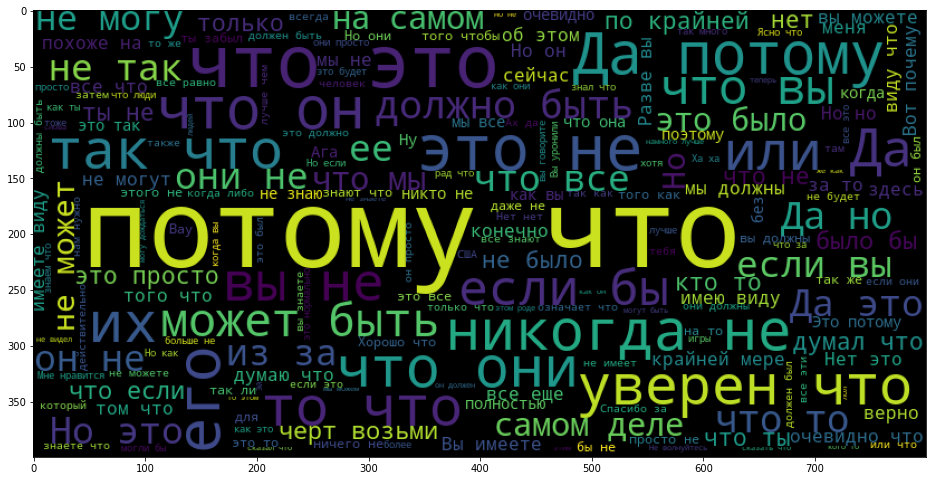

In [27]:
plt.figure(figsize=(16, 12))
wordcloud.generate(
    " ".join([s for s in train.loc[train['label'] == 1, 'rus_comment'].values if isinstance(s, str)])
)
plt.imshow(wordcloud);

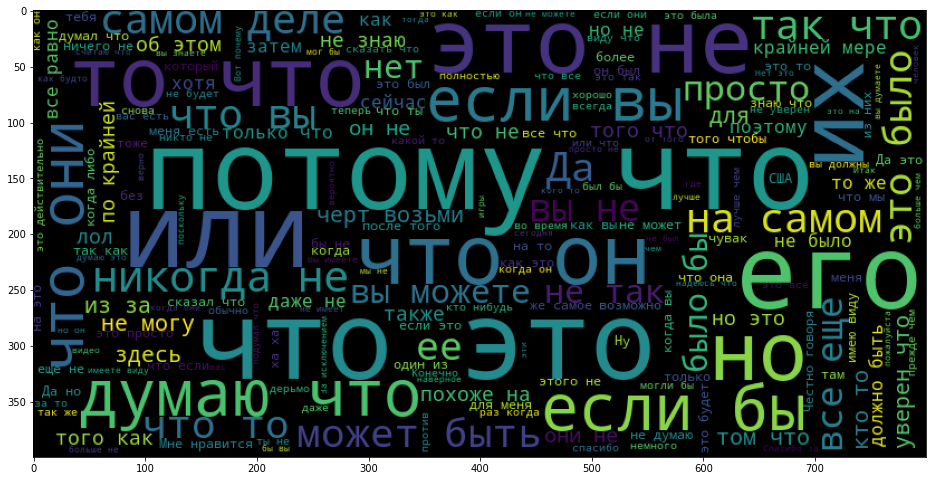

In [28]:
plt.figure(figsize=(16, 12))
wordcloud.generate(
    " ".join([s for s in train.loc[train['label'] == 0, 'rus_comment'].values if isinstance(s, str)])
)
plt.imshow(wordcloud);